<a href="https://colab.research.google.com/github/hamaminezakaria/Master-Data-Augmentation/blob/main/Glaucoma_without_Dataaugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t
import cv2
import warnings
import shutil
import os
#import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout
from matplotlib import pyplot


# Sklearn utils.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# Keras.
import cv2
import numpy as np
import os
import random
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras import layers
from keras.applications.resnet50 import ResNet50
from keras.applications import DenseNet121
from keras.utils import Sequence
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

# to generate data augmentation a partir de aptos 2019 preprocessed
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import os
import cv2
%matplotlib inline

In [2]:

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
#unzip the dataset

# for the train
!unzip /content/drive/MyDrive/dataset/Glaucoma/Glaucoma_dataset.zip


Archive:  /content/drive/MyDrive/dataset/Glaucoma/Glaucoma_dataset.zip
   creating: Glaucoma_dataset/
   creating: Glaucoma_dataset/test/
   creating: Glaucoma_dataset/test/Glaucome/
  inflating: Glaucoma_dataset/test/Glaucome/g.0005.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0008.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0011.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0012.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0018.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0019.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0020.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0021.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0024.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0026.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0030.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0035.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0039.jpg  
  inflating: Glaucoma_dataset/test/Glaucome/g.0040.jpg  
  inflating: Glauco

In [ ]:
!rm -r train
!rm -r test

In [4]:
path_train = 'train'
path_test = 'test'


def createBatchFolder(pathName):
    try:
        os.mkdir(pathName)
    except OSError:
        print ("Creation of the directory %s failed" % pathName)
    else:
        print ("Successfully created the directory %s " % pathName)
    finally:
        for i in range(2):
          try:
              pathBatch = pathName+'/'+str(i)
              os.mkdir(pathBatch)
          except OSError:
              print ("Creation of the directory %s failed" % pathName)

# call the create path function
createBatchFolder(path_train)
createBatchFolder(path_test)

Successfully created the directory train 
Successfully created the directory test 


In [5]:


import random
import os
BASE_DIR = "/content/Glaucoma_dataset/train/Non-glaucome"
NEW_DIR= "train/0"

list_dir =  os.listdir(BASE_DIR)

for images in list_dir:
    image = cv2.imread(BASE_DIR + "/"+ images)
    image = cv2.resize(image,(299,299))
    try:
        cv2.imwrite(NEW_DIR + "/" + images,image)
    except Exception: 
        pass
    

BASE_DIR = "/content/Glaucoma_dataset/train/Glaucome"
NEW_DIR= "train/1"

list_dir =  os.listdir(BASE_DIR)

for images in list_dir:
    image = cv2.imread(BASE_DIR + "/"+ images)
    image = cv2.resize(image,(299,299))
    try:
        cv2.imwrite(NEW_DIR + "/" + images,image)
    except Exception: 
        pass

In [6]:
import random
import os
BASE_DIR = "/content/Glaucoma_dataset/test/Non-glaucome"
NEW_DIR= "test/0"

list_dir =  os.listdir(BASE_DIR)

for images in list_dir:
    image = cv2.imread(BASE_DIR + "/"+ images)
    image = cv2.resize(image,(299,299))
    try:
        cv2.imwrite(NEW_DIR + "/" + images,image)
    except Exception: 
        pass
    

BASE_DIR = "/content/Glaucoma_dataset/test/Glaucome"
NEW_DIR= "test/1"

list_dir =  os.listdir(BASE_DIR)

for images in list_dir:
    image = cv2.imread(BASE_DIR + "/"+ images)
    image = cv2.resize(image,(299,299))
    try:
        cv2.imwrite(NEW_DIR + "/" + images,image)
    except Exception: 
        pass

In [7]:
!ls train/0 | wc -l
!ls train/1 | wc -l

!ls test/0 | wc -l
!ls test/1 | wc -l

2387
1477
756
234


In [8]:
from keras.preprocessing.image import ImageDataGenerator
import numpy
import math
batchSize = 32

train_datagen = ImageDataGenerator(
      rescale=1./255,
      ) 

train_generator = train_datagen.flow_from_directory(
      'train',
      target_size=(299,299),
      #target_size=(224,224),
      color_mode='rgb',
      batch_size=batchSize,
      class_mode='binary',
      shuffle=True)

  # ******* for validation dataset
val_generator = train_datagen.flow_from_directory(
      'test',
      target_size=(299,299),
      #target_size=(224,224),
      class_mode='binary',    
      color_mode='rgb',
  )


Found 3864 images belonging to 2 classes.
Found 990 images belonging to 2 classes.


# Inception

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras import layers

fc_layers = [1024, 512, 128]
dropout = 0.5


pre_trained_model = InceptionV3(input_shape = (299,299,3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
        layer.trainable = False

x = Flatten(input_shape=pre_trained_model.output.shape)(pre_trained_model.output)

for fc in fc_layers:
    x = Dense(fc, activation='relu')(x)
    x = Dropout(dropout)(x)

predictions = Dense(1, activation='sigmoid', name='pred')(x)
model = Model(inputs=[pre_trained_model.input], outputs=[predictions])


model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.0005),
    metrics=['accuracy']
)


#DenseeNet121

In [ ]:
###############  DenseNet121 ######################
from keras.applications.densenet import DenseNet121
from keras import optimizers

fc_layers = [1024, 512, 128]
dropout = 0.5


pre_trained_model = DenseNet121(input_shape = (224,244,3),include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
        layer.trainable = False
        
#model = Sequential()
x = Flatten(input_shape=pre_trained_model.output.shape)(pre_trained_model.output)
x = Dense(1024, activation='sigmoid')(x)
predictions = Dense(2, activation='softmax', name='pred')(x)
model = Model(inputs=[pre_trained_model.input], outputs=[predictions])

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.0005),
    metrics=['accuracy']
)
print(model.summary())

#ResNet50

In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization

pre_trained_model = ResNet50(include_top=False, weights='imagenet', input_shape=(299,299,3))

model = Sequential()
model.add(pre_trained_model)

for layer in pre_trained_model.layers:
        layer.trainable = False

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(520))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.7))

model.add(Dense(2, activation='softmax'))

adam = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])



#VGG-16

In [ ]:
############# VGG16 #############
from tensorflow.keras.applications import VGG16
from tensorflow.python.keras import Model
from keras import optimizers
from tensorflow.python.keras.layers import Dense, Flatten

fc_layers = [1024, 512, 256]
dropout = 0.5

def build_vgg16(num_classes, img_size):   
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=img_size)

    for layer in vgg16.layers:
        layer.trainable = False
        
    x = Flatten(input_shape=vgg16.output.shape)(vgg16.output)
    for fc in fc_layers:
      x = Dense(fc, activation='relu')(x)
      x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='softmax', name='pred')(x)
    model = Model(inputs=[vgg16.input], outputs=[predictions])
    
    return model

model = build_vgg16(2,(224,224,3))
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.0005),
    metrics=['accuracy']
)
print(model.summary())

#VGG-19

In [ ]:
def build_vgg19(num_classes, img_size):
    from tensorflow.python.keras.applications import VGG19
    from tensorflow.python.keras import Model
    from tensorflow.python.keras.layers import Dense, Flatten

    fc_layers = [1024, 512, 256]
    dropout = 0.5

    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=img_size)

    for layer in vgg19.layers:
        layer.trainable = False

    # customize last layers
    x = Flatten(input_shape=vgg19.output.shape)(vgg19.output)

    for fc in fc_layers:
      x = Dense(fc, activation='relu')(x)
      x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation='softmax', name='pred')(x)
    model = Model(inputs=[vgg19.input], outputs=[predictions])



# Compile and train model

In [13]:
earlystopper = EarlyStopping(
            monitor = "val_accuracy",
            mode="auto",
            patience=10,
            verbose=1
  )
model_checkpoint = ModelCheckpoint(
              'model.5',
              monitor='val_accuracy',
              verbose=1,
              save_best_only=True
  )

history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples//batchSize),
    epochs=20,
    validation_data = val_generator,
    validation_steps = math.ceil(val_generator.samples//batchSize),callbacks=[model_checkpoint,earlystopper],
    verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
120/120 [==============================] - 42s 167ms/step - loss: 7.9158 - accuracy: 0.5946 - val_loss: 0.5995 - val_accuracy: 0.6802

Epoch 00001: val_accuracy improved from -inf to 0.68021, saving model to model.5
INFO:tensorflow:Assets written to: model.5/assets
Epoch 2/20
120/120 [==============================] - 18s 151ms/step - loss: 1.4340 - accuracy: 0.7247 - val_loss: 0.4539 - val_accuracy: 0.8208

Epoch 00002: val_accuracy improved from 0.68021 to 0.82083, saving model to model.5
INFO:tensorflow:Assets written to: model.5/assets
Epoch 3/20
120/120 [==============================] - 18s 151ms/step - loss: 0.6210 - accuracy: 0.7795 - val_loss: 0.4368 - val_accuracy: 0.8521

Epoch 00003: val_accuracy improved from 0.82083 to 0.85208, saving model to model.5
INFO:tensorflow:Assets written to: model.5/assets
Epoch 4/20
120/120 [==============================] - 19s 156ms/step - loss: 0.4843 - accuracy: 0.8128 - val_loss: 0.3312 - val_accuracy: 0.8865

Epoch 00004: val_

In [ ]:
# saving the model
model.save("model.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


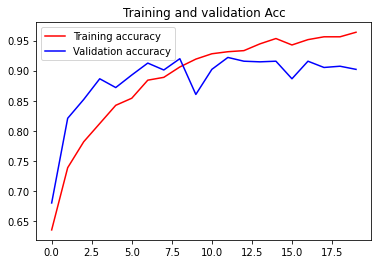

<Figure size 432x288 with 0 Axes>

In [14]:
# display the performance of the model graphically
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation Acc')
plt.legend(loc=0)
plt.figure()

plt.show()

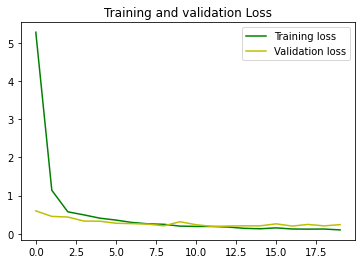

<Figure size 432x288 with 0 Axes>

In [15]:
# display the performance of the model graphically
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [16]:
score = model.evaluate(val_generator)
print(score)

31/31 [==============================] - 5s 147ms/step - loss: 0.2380 - accuracy: 0.9030
[0.23804321885108948, 0.903030276298523]


# Confusion_Matrix_Test

In [17]:
from tqdm import tqdm
# Store the data in X_train, y_train variables by iterating over the batches

val_generator.reset()
x_test, y_test = next(val_generator)
for i in tqdm(range(int(val_generator.samples/batchSize)-1)): #1st batch is alread fetched before the for loop
  img, label = next(val_generator)
  x_test = np.append(x_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
  
# do the predictions
y_predicted = model.predict(x_test)
y_pred = np.round(y_predicted)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
font = {
'family': 'Times New Roman',
'size': 12
}
plt.rc('font', **font)
mat = confusion_matrix(np.round(y_test),y_pred)
print(mat)
#class_labels = list(val_generator.class_indices.keys())
class_labels=['0','1']
report = classification_report(np.round(y_test), y_pred, target_names=class_labels)
print(report)

100%|██████████| 29/29 [00:08<00:00,  3.51it/s]


[[645  86]
 [  6 223]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       731
           1       0.72      0.97      0.83       229

    accuracy                           0.90       960
   macro avg       0.86      0.93      0.88       960
weighted avg       0.93      0.90      0.91       960

